# Customer Profitability Modeling Project

### Project Objective

The goal of this project is to predict customer profitability categories 
(Low, Medium, High) using demographic, credit, and transaction-level features.

This analysis aims to simulate how a financial institution could:
- Identify high-value customers
- Understand drivers of profitability
- Support marketing or credit strategy decisions

In [3]:
# importing all the libaries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


The three csv files used for this project were sourced from Kaggle and can be found here: https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets

In [4]:
# loading the three dfs we are working with
cards_data = pd.read_csv('cards_data.csv')
users = pd.read_csv('users_data.csv')
transactions = pd.read_csv('transactions_data.csv')

### Data Cleaning + Preprocessing
Before analyzing any data, checking and ensuring usability and consistency of the structure throught the dataset is imporant. While I know the datasets I am working with are fairly standardize, I still will be using standard validation checks and ways to enchance the dataset for insights and for the analysis I will be doing.


First focusing on the User dataset, the first step I took is to look for any nulls, duplicates, and to ensure standard formating throughout the dataset. These cleaning steps will allow us to analyze our data as accurate as possible.

In [5]:
# focusing on the user table
users.isna() #checking for any nulls
users.duplicated() # looking for any duplicate rows in the dataset.

# Ensuring standard format throughout the columns

users['gender']= users['gender'].str.strip().str.lower()
users['gender'] = users['gender'].replace({'m': 'Male', 'male': 'Male', 'f': 'Female', 'female':'Female'}) # ensuring consistent formatting of Female and Male
users['gender']

users['yearly_income'] = users['yearly_income'].str.lstrip('$') #striping the dollar sign
users['total_debt'] = users['total_debt'].str.lstrip('$')
users['per_capita_income'] = users['per_capita_income'].str.lstrip('$')

users['yearly_income'] = users['yearly_income'].astype(int) # turning columns into int type for analysis later
users['total_debt'] = users['total_debt'].astype(int)
users['per_capita_income'] = users['per_capita_income'].astype(int)


Next, both a new coulmn that bins age and yearly income of users was created. This binning will help us be able to evaluate trends within our dataset at a different level.

In [6]:
# Creating a new column that creates age bins
bins = [0, 18, 25, 35, 50, 65, 100]
labels = ['<18', '18-24', '25-34', '35-49', '50-64', '65+']
users['age_group'] = pd.cut(users['current_age'], bins=bins, labels=labels)

In [7]:
# Creating a new column that categorizes yearly income levels
def income_class(value):
    if value < 56600:
        return "Lower Class"
    elif 56600 <= value < 169800:
        return "Middle Class"
    else:
        return "Upper Class"

users['income_class'] = users['yearly_income'].map(income_class)
# users['income_class']

In addition to checking for nulls, duplicates, and ensuring standard formatting throughout the cards_data dataset, we also created two new columns includuing the age of someone's account and how many years since it's been since they changed their cards. During our EDA, we are going to see how these two meterics, if at all, correlate to others within our datasets.

In [8]:
# cleaning cards info dataset
cards_data.isna() #checking for any nulls
cards_data.duplicated() # looking for any duplicate rows in the dataset.

# Ensuring standard format throughout the columns
cards_data['has_chip']= cards_data['has_chip'].str.strip().str.lower()
cards_data['has_chip']= cards_data['has_chip'].replace({'yes': 'Yes', 'y': 'Yes', 'no': 'No', 'n':'No'}) # ensuring consistent formatting of Female and Male

cards_data['card_on_dark_web']= cards_data['card_on_dark_web'].str.strip().str.lower()
cards_data['card_on_dark_web']= cards_data['card_on_dark_web'].replace({'yes': 'Yes', 'y': 'Yes', 'no': 'No', 'n':'No'}) # ensuring consistent formatting of Female and Male

# changing dates from string to datetime type
cards_data['expires']= pd.to_datetime(cards_data['expires'])
cards_data['acct_open_date']= pd.to_datetime(cards_data['acct_open_date'])

# striping the dollar sign and turning columns into int type for analysis later
cards_data['credit_limit'] = cards_data['credit_limit'].str.lstrip('$')
cards_data['credit_limit'] = cards_data['credit_limit'].astype(int)

/var/folders/74/_19dm8xn5ys5fmywmrbsqcb80000gn/T/ipykernel_17197/4056639081.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cards_data['expires']= pd.to_datetime(cards_data['expires'])
/var/folders/74/_19dm8xn5ys5fmywmrbsqcb80000gn/T/ipykernel_17197/4056639081.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cards_data['acct_open_date']= pd.to_datetime(cards_data['acct_open_date'])


In [9]:
# Creating new columns from cards related data for potential features for the model

cards_data['account_age'] = 2019 - pd.to_datetime(cards_data['acct_open_date']).dt.year
cards_data['pin_change_gap'] = 2019 - cards_data['year_pin_last_changed']

In [10]:
#transactions dataset

transactions.isna() #checking for any nulls
transactions.duplicated() # looking for any duplicate rows in the dataset.

# striping the dollar sign and turning columns into float type for analysis later
transactions['amount'] = transactions['amount'].str.lstrip('$')
transactions['amount'] = transactions['amount'].astype(float)

# changing dates from string to datetime type
transactions['date']= pd.to_datetime(transactions['date'])

# fixing the zip code column to be from float to type str
transactions['zip'] = transactions['zip'].astype(str).str.replace('.0', '',) # converting to string first
transactions[transactions['zip'].str.len() < 5] # checking for short ZIP codes that may have lost a leading 0
transactions['zip'] = transactions['zip'].str.zfill(5) # adding leading zeros to any zips that have a length less than 5

In [11]:
# Creating new columns from transactions related data for potential features for the model
month = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
transactions['transaction_month'] = transactions['date'].dt.month.map(month)
transactions['transaction_year'] = transactions['date'].dt.year

In [12]:
# Assuming that all negative transactions are returns, removing them
transactions = transactions[transactions['amount'] >= 0]

After cleaning all the datasets and creating additional columns, all the datasets have now been joined on user_id so we can explore the sets altogehter now.

In [13]:
# merging all three DFs on "id"

merged_df = pd.merge(transactions, cards_data, left_on='card_id', right_on='id', how='left').merge(users, left_on='client_id_x', right_on='id', how='left')
merged_df.shape
merged_df.head()


,id_x,date,client_id_x,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,age_group,income_class
0,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,...,604 Pine Street,40.80,-91.12,18076,36853,112139,834,5,35-49,Lower Class
1,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,...,2379 Forest Lane,33.18,-117.29,16894,34449,36540,686,3,35-49,Lower Class
2,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,...,903 Hill Boulevard,41.42,-87.35,26168,53350,128676,685,5,50-64,Lower Class
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,...,166 River Drive,38.86,-76.60,33529,68362,96182,711,2,50-64,Middle Class
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464,...,14780 Plum Lane,40.84,-73.87,25537,52065,98613,828,5,35-49,Lower Class


## Exploratory Data Analysis

### 1. General Dataset Overview
Initial exploration of each dataframe

In [14]:
users.info()
users.describe()
users.head()
users.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 2000 non-null   int64   
 1   current_age        2000 non-null   int64   
 2   retirement_age     2000 non-null   int64   
 3   birth_year         2000 non-null   int64   
 4   birth_month        2000 non-null   int64   
 5   gender             2000 non-null   object  
 6   address            2000 non-null   object  
 7   latitude           2000 non-null   float64 
 8   longitude          2000 non-null   float64 
 9   per_capita_income  2000 non-null   int64   
 10  yearly_income      2000 non-null   int64   
 11  total_debt         2000 non-null   int64   
 12  credit_score       2000 non-null   int64   
 13  num_credit_cards   2000 non-null   int64   
 14  age_group          1999 non-null   category
 15  income_class       2000 non-null   object  
dtypes: cat

id                      int64
current_age             int64
retirement_age          int64
birth_year              int64
birth_month             int64
gender                 object
address                object
latitude              float64
longitude             float64
per_capita_income       int64
yearly_income           int64
total_debt              int64
credit_score            int64
num_credit_cards        int64
age_group            category
income_class           object
dtype: object

In [15]:
cards_data.info()
cards_data.describe()
cards_data.head()
cards_data.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     6146 non-null   int64         
 1   client_id              6146 non-null   int64         
 2   card_brand             6146 non-null   object        
 3   card_type              6146 non-null   object        
 4   card_number            6146 non-null   int64         
 5   expires                6146 non-null   datetime64[ns]
 6   cvv                    6146 non-null   int64         
 7   has_chip               6146 non-null   object        
 8   num_cards_issued       6146 non-null   int64         
 9   credit_limit           6146 non-null   int64         
 10  acct_open_date         6146 non-null   datetime64[ns]
 11  year_pin_last_changed  6146 non-null   int64         
 12  card_on_dark_web       6146 non-null   object        
 13  acc

id                                int64
client_id                         int64
card_brand                       object
card_type                        object
card_number                       int64
expires                  datetime64[ns]
cvv                               int64
has_chip                         object
num_cards_issued                  int64
credit_limit                      int64
acct_open_date           datetime64[ns]
year_pin_last_changed             int64
card_on_dark_web                 object
account_age                       int32
pin_change_gap                    int64
dtype: object

In [16]:
transactions.info()
transactions.describe()
transactions.head()
transactions.dtypes

<class 'pandas.core.frame.DataFrame'>
Index: 12645866 entries, 1 to 13305914
Data columns (total 14 columns):
 #   Column             Dtype         
---  ------             -----         
 0   id                 int64         
 1   date               datetime64[ns]
 2   client_id          int64         
 3   card_id            int64         
 4   amount             float64       
 5   use_chip           object        
 6   merchant_id        int64         
 7   merchant_city      object        
 8   merchant_state     object        
 9   zip                object        
 10  mcc                int64         
 11  errors             object        
 12  transaction_month  object        
 13  transaction_year   int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(5), object(6)
memory usage: 1.4+ GB


id                            int64
date                 datetime64[ns]
client_id                     int64
card_id                       int64
amount                      float64
use_chip                     object
merchant_id                   int64
merchant_city                object
merchant_state               object
zip                          object
mcc                           int64
errors                       object
transaction_month            object
transaction_year              int32
dtype: object

### 2. Demographics of Users

The following graphs and other visuals explore different traits about the users within the dataset including age, income, gender, and so much more. Understanding the types of users the dataset comprises of allows for the creation of more interesting analysis and visuals. Furthermore, evaluating demographic data will allow us to understand how representative our sample is of its overall population and how reliable our model will be.

Text(0.5, 1.0, 'Distribution of Age')

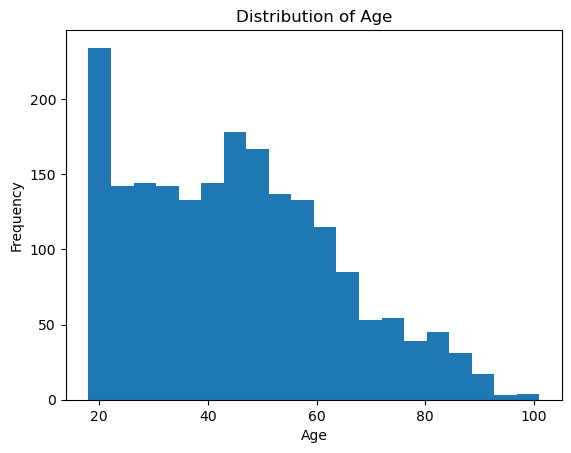

In [17]:
# Age Distribution
users['current_age'].plot(kind='hist', bins=20)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Distribution of Age")

Text(0.5, 1.0, 'Distribution of Age Group')

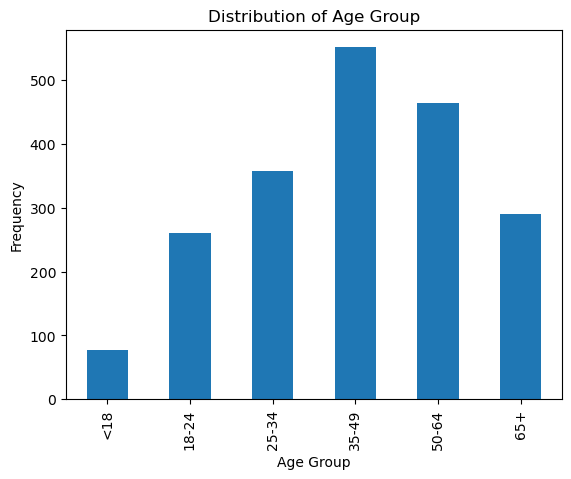

In [18]:
users['age_group'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Age Group")
plt.ylabel("Frequency")
plt.title("Distribution of Age Group")

Text(0.5, 1.0, 'Distribution of Gender')

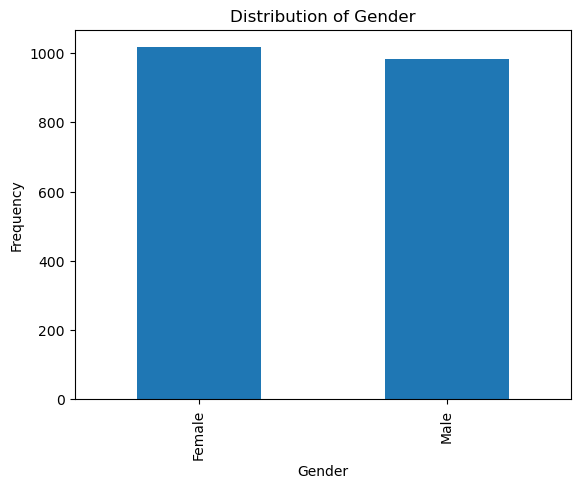

In [19]:
# Gender Distribution
users['gender'].value_counts().plot(kind='bar')
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.title("Distribution of Gender")

Text(0.5, 1.0, 'Distribution of Yearly Income')

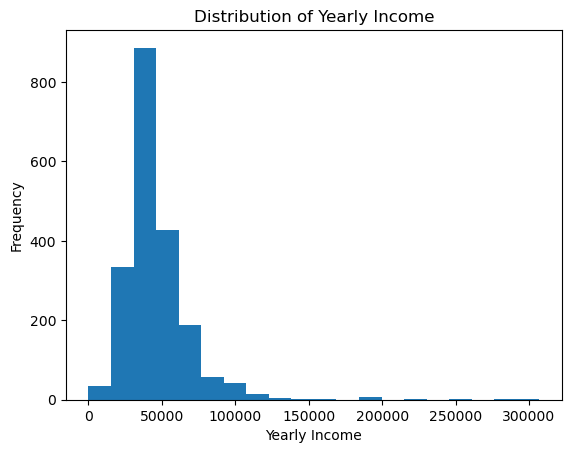

In [20]:
# Income and Debt

plt.hist(users['yearly_income'], bins=20)
plt.xlabel("Yearly Income")
plt.ylabel("Frequency")
plt.title("Distribution of Yearly Income")

<Axes: >

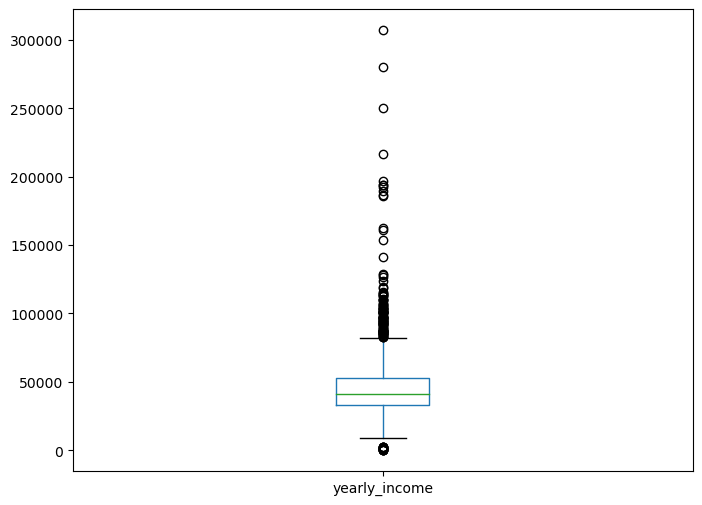

In [21]:
users.boxplot(column=['yearly_income'], grid=False, fontsize=10, figsize=(8,6))
#users.boxplot(column=['per_capita_income'], grid=False, fontsize=10, figsize=(8,6))

Text(0.5, 1.0, 'Distribution of Income Class')

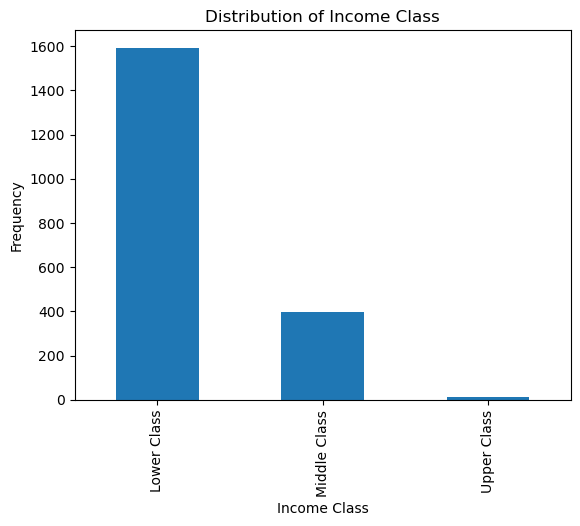

In [22]:
# Income Class Distribution
users['income_class'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Income Class")
plt.ylabel("Frequency")
plt.title("Distribution of Income Class")

Text(0.5, 1.0, 'Distribution of Debt')

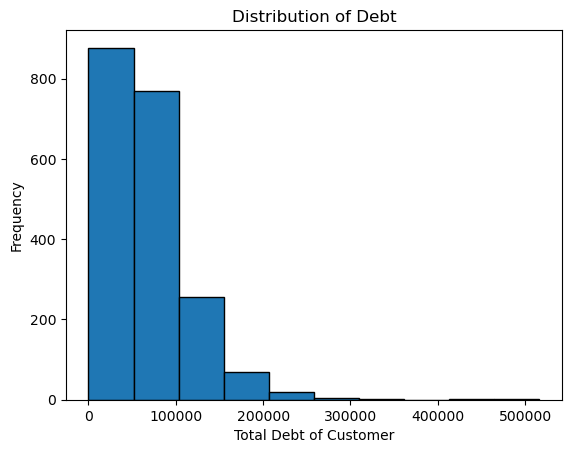

In [23]:
# total debt
plt.hist(users['total_debt'], edgecolor='black')
plt.xlabel("Total Debt of Customer")
plt.ylabel("Frequency")
plt.title("Distribution of Debt")

<Axes: title={'center': 'yearly_income'}, xlabel='age_group'>

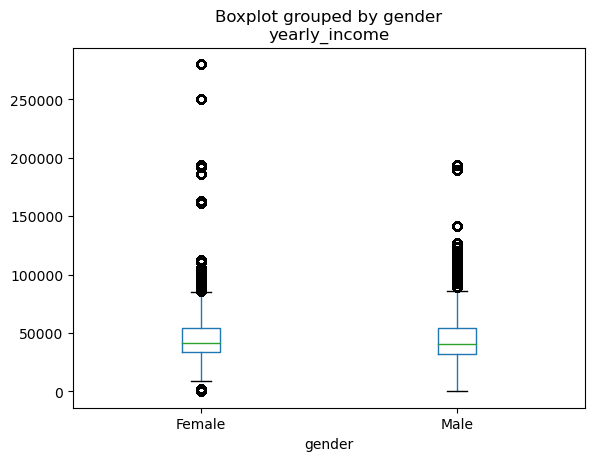

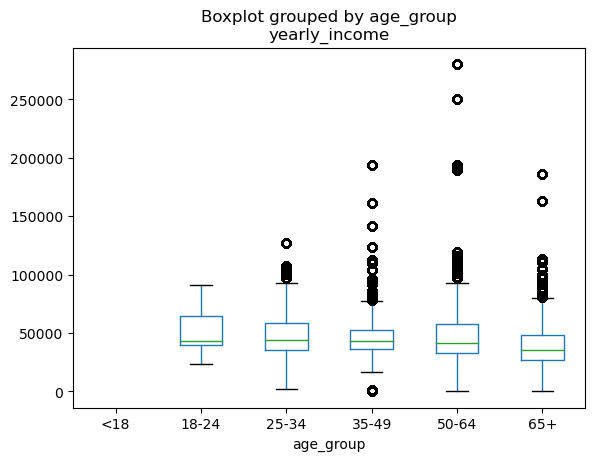

In [24]:
# income vs age and gender
merged_df.boxplot(column=['yearly_income'], by='gender', grid=False)
merged_df.boxplot(column=['yearly_income'], by='age_group', grid=False)

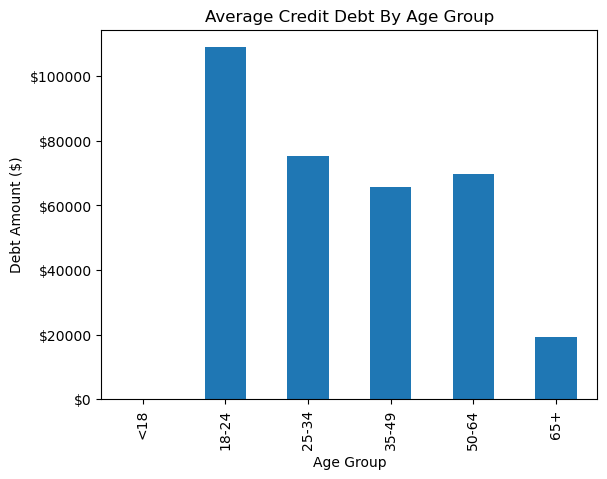

In [25]:
# debt vs age (exploring since some sort of correlation)
# on avg, which age group has the most debt

ax = merged_df.groupby('age_group')['total_debt'].mean().plot(kind='bar', title='Average Credit Debt By Age Group')
ax.set_xlabel('Age Group')
ax.set_ylabel('Debt Amount ($)')
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)

<Axes: xlabel='current_age', ylabel='total_debt'>

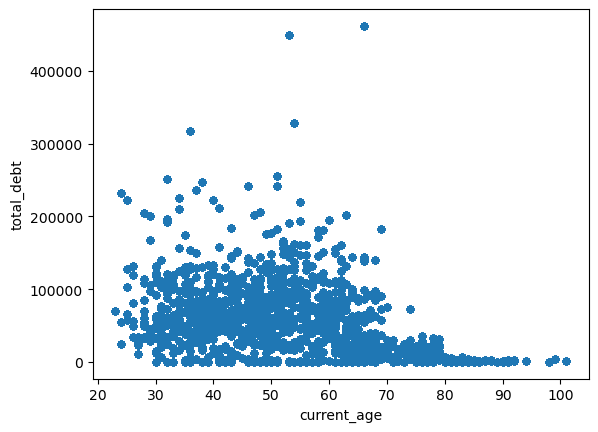

In [26]:
merged_df.plot(kind='scatter', x = 'current_age', y = 'total_debt')

<Axes: ylabel='total_debt'>

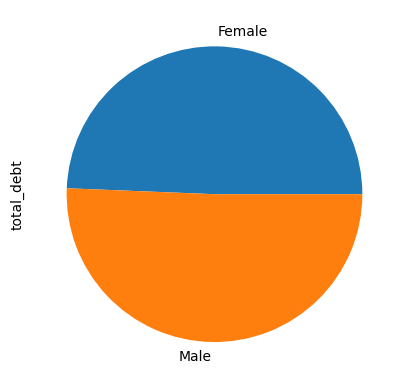

In [27]:
# debt vs gender 
# on avg, which age group has the most debt
merged_df.groupby('gender')['total_debt'].mean().plot(kind='pie') # not that much of a difference

### 3. Geographic Insights

The scatterplot of the longitutde and latitude coordinates of the card users in this dataset create a rough outline of the United States Map which suggest that we have a decently even spread in terms of geophrapical representation of our dataset. There are clusters around major cities(e.g., NYC, LA, Chicago). This provides a spatial sense of the data.

Text(0, 0.5, 'Latitude')

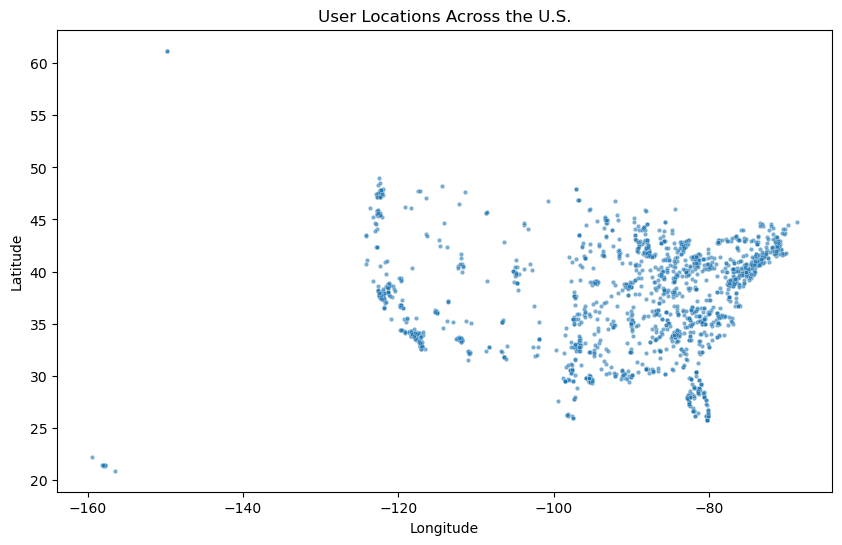

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', data=users, s=10, alpha=0.6)
plt.title("User Locations Across the U.S.")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

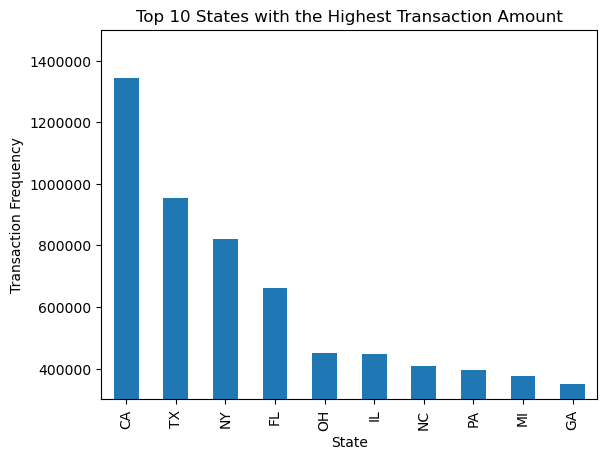

In [29]:
# State with the most transaction amount

ax = merged_df['merchant_state'].value_counts().head(10).plot(kind='bar', title='Top 10 States with the Highest Transaction Amount')
ax.set_xlabel('State')
ax.set_ylabel('Transaction Frequency')
ax.set_ylim(300000, 1500000)
ax.yaxis.get_major_formatter().set_scientific(False)

The distribution the states with the highest amount of transactions also provide a spatial sense of the data. These states are the most populated states within the Untied States.

### 4. Transaction Behavior

Now deep-diving into the various transactions and looking at how users within the dataset are using their cards including evaluating seasonality trends and the dollar amount of transactions as well.

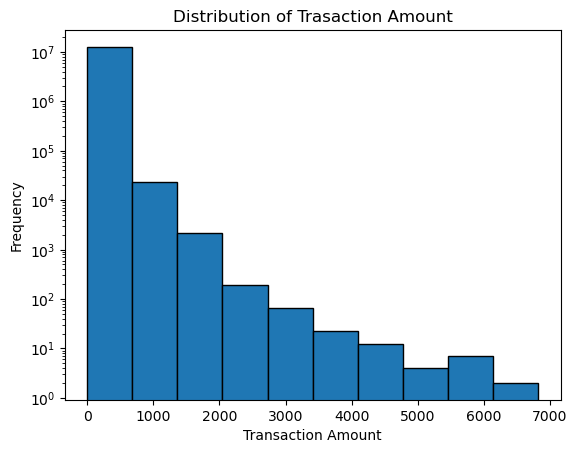

In [30]:
plt.hist(transactions['amount'], edgecolor='black')
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Trasaction Amount")
plt.yscale('log')

<Axes: title={'center': 'amount'}, xlabel='gender'>

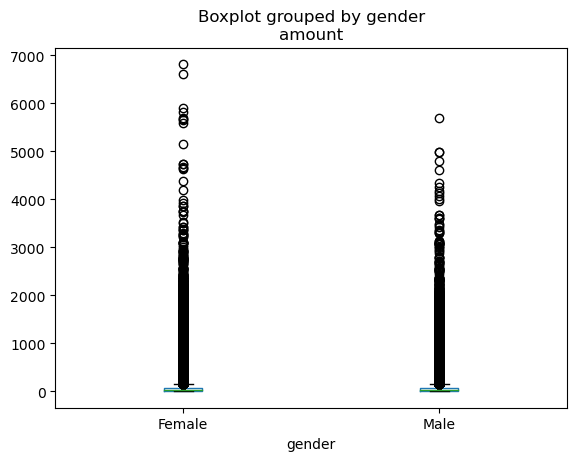

In [31]:
merged_df.boxplot(column=['amount'], by='gender', grid=False)

<Axes: title={'center': 'amount'}, xlabel='card_brand'>

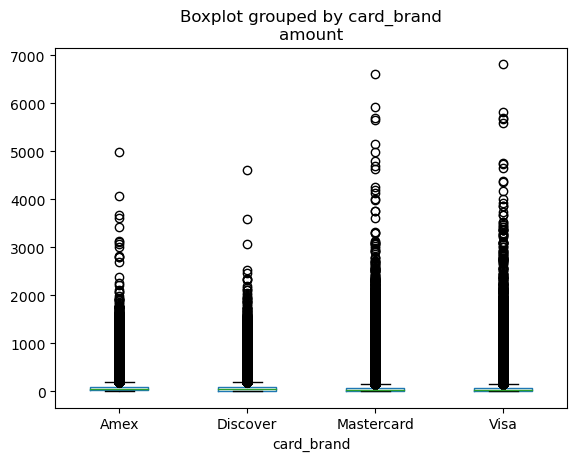

In [32]:
merged_df.boxplot(column=['amount'], by='card_brand', grid=False)

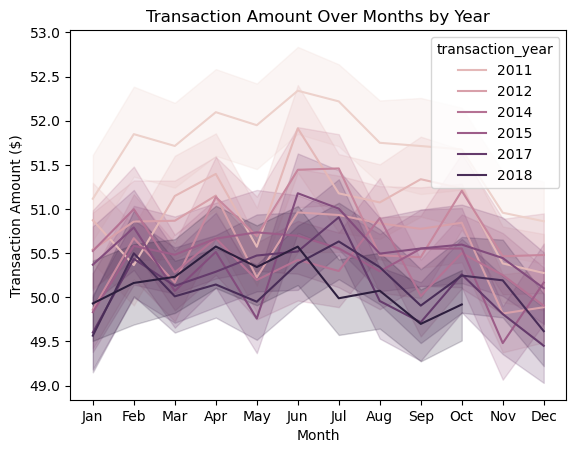

In [33]:
# Number of transactions made throughout the year
sns.lineplot(x='transaction_month', y='amount', hue='transaction_year', data=transactions)
plt.title('Transaction Amount Over Months by Year')
plt.xlabel('Month')
plt.ylabel('Transaction Amount ($)')
#plt.subplots(figsize=(20, 5))
plt.show()

<Axes: xlabel='use_chip'>

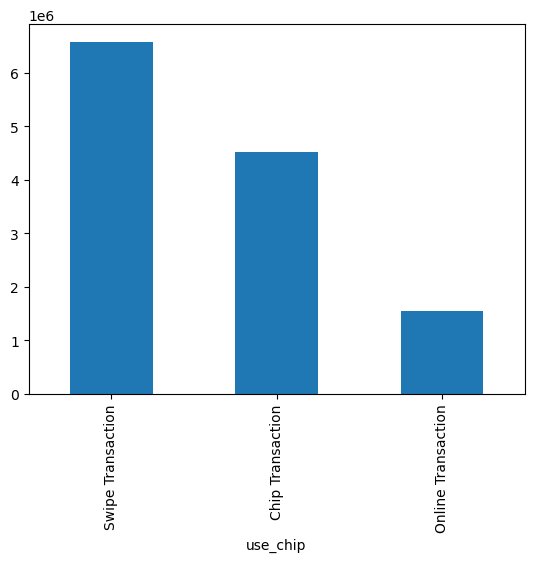

In [34]:
transactions['use_chip'].value_counts().plot(kind='bar')

<Axes: xlabel='has_chip'>

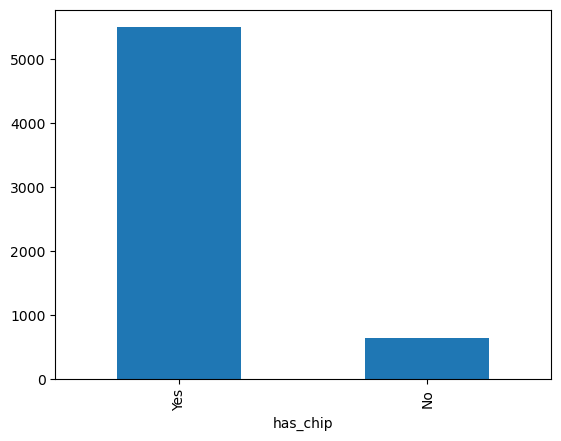

In [35]:
cards_data['has_chip'].value_counts().plot(kind='bar')

In [36]:
cards_has_no_chip =cards_data.query("has_chip == 'No'")
cards_has_chip =cards_data.query("has_chip == 'Yes'")
cards_has_chip['card_brand'].value_counts()
cards_has_no_chip['card_brand'].value_counts()

card_brand
Mastercard    341
Visa          250
Amex           35
Discover       20
Name: count, dtype: int64

In trying to evaluate which card brand within the dataset acquires the highest spenders, American Express cardholders despite having a smaller sample in the dataset, are actually some of the highest spenders.

In [37]:
# which card brand has the highest spenders (transaction average amount by card brand)
merged_df.groupby('card_brand')['amount'].mean() # amex on average

card_brand
Amex          64.788869
Discover      63.076568
Mastercard    47.551670
Visa          51.606567
Name: amount, dtype: float64

In [38]:
# number of transactions by card brand

merged_df['card_brand'].value_counts()

# number of each type of card brand in dataset

cards_data['card_brand'].value_counts()

3209 / 7157399 # mastercard ratio of num of transactions / num of brand's card

402 / 854490 # Amex ratio

# despite amex having less card in dataset the ratio of transactions to cards is higher than mastercards

0.0004704560615103746

### 5. Credit Behavior

The following visuals are evaluating users credit scores and how, if it all, a users total debt and income play a role.

Text(0.5, 1.0, 'Distribution of Credit Scores')

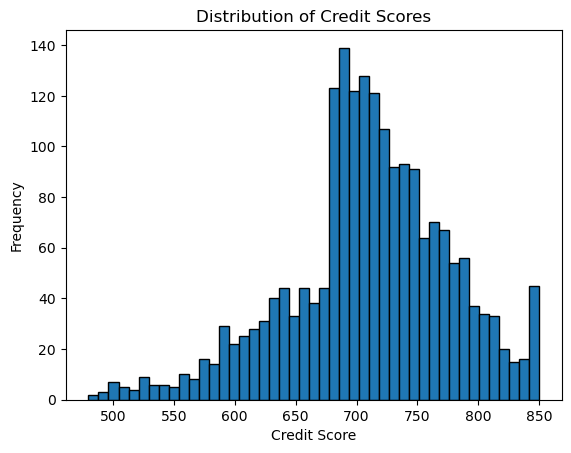

In [39]:
 # credit score

plt.hist(users['credit_score'], bins= 45, edgecolor='black')
plt.xlabel("Credit Score")
plt.ylabel("Frequency")
plt.title("Distribution of Credit Scores")

<Axes: xlabel='credit_score', ylabel='total_debt'>

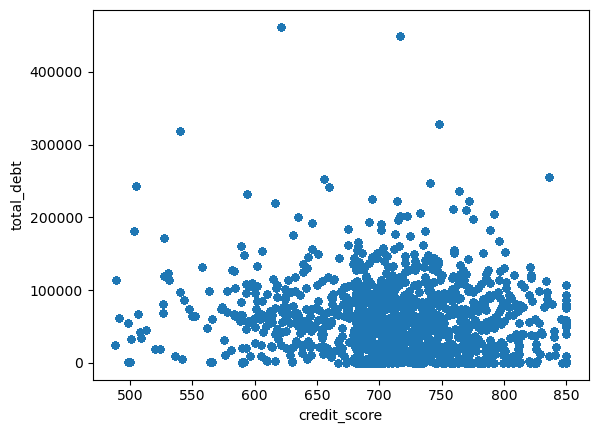

In [40]:
# Relationship between credit score and debt/income

# credit_score vs. total_debt
merged_df.plot(kind='scatter', x = 'credit_score', y = 'total_debt')

<Axes: xlabel='credit_score', ylabel='income_class'>

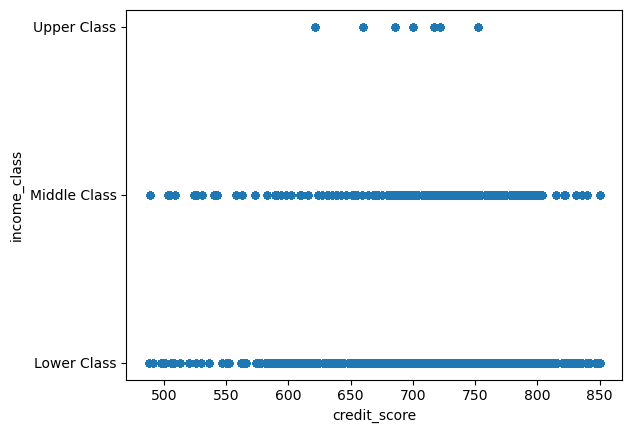

In [41]:
# credit score vs income_class
merged_df.plot(kind='scatter', x = 'credit_score', y = 'income_class')

<Axes: title={'center': 'credit_score'}, xlabel='income_class'>

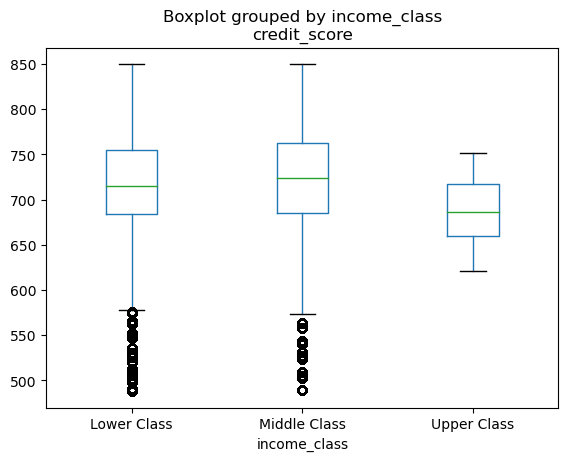

In [42]:
merged_df.boxplot(column=['credit_score'], by='income_class', grid=False)

<Axes: title={'center': 'credit_score'}, xlabel='card_brand'>

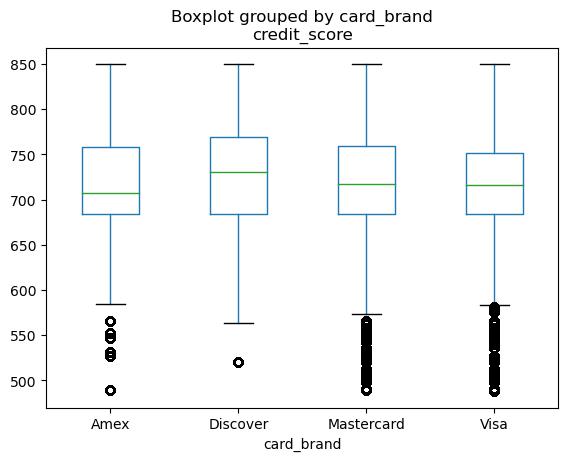

In [43]:
merged_df.boxplot(column=['credit_score'], by='card_brand', grid=False)

### 6. Card Behavior

This sections evlauates the different types of cards users have and how they interact with them. As shown below, Mastercard and Visa cards dominate our particular sample which provides a decent spread when comparing to known populatin trends.

(array([416., 388., 449., 376.,   0., 206., 105.,  40.,  17.,   3.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

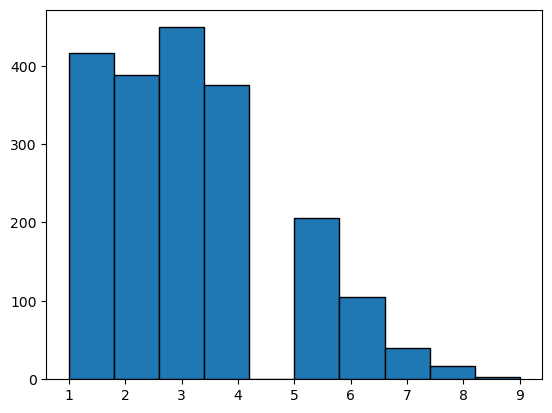

In [45]:
# cards issued per user
plt.hist(users['num_credit_cards'], edgecolor='black')

<Axes: xlabel='card_type'>

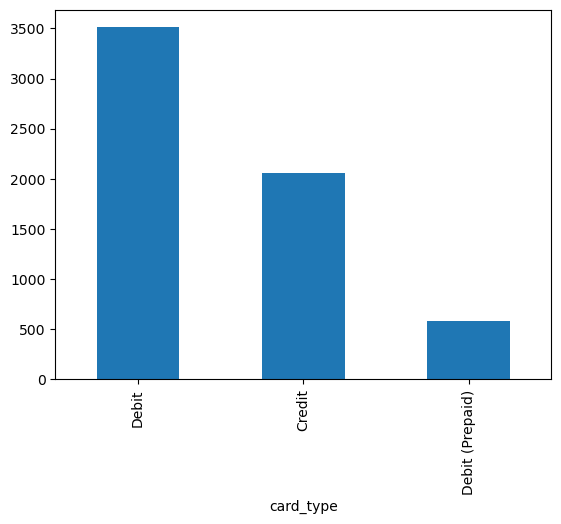

In [46]:
# card types
cards_data['card_type'].value_counts().plot(kind='bar')

<Axes: xlabel='card_brand'>

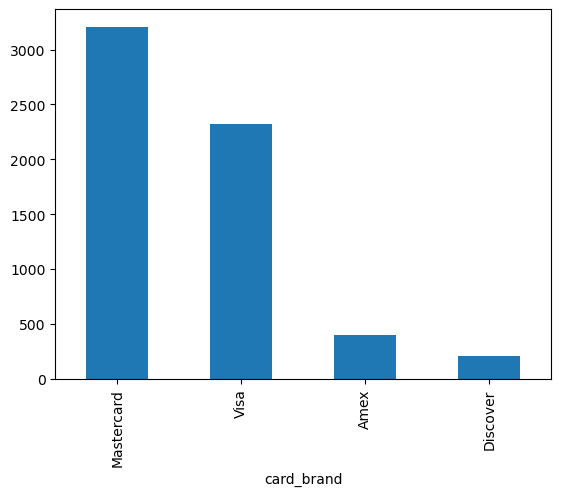

In [47]:
# card brand
cards_data['card_brand'].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'Distribution of Credit Limits')

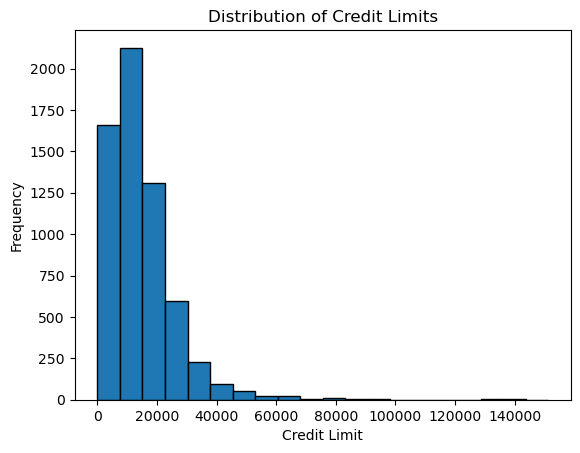

In [49]:
# credit limit

plt.hist(cards_data['credit_limit'], edgecolor='black', bins=20)
plt.xlabel("Credit Limit")
plt.ylabel("Frequency")
plt.title("Distribution of Credit Limits")

<Axes: title={'center': 'credit_limit'}, xlabel='card_brand'>

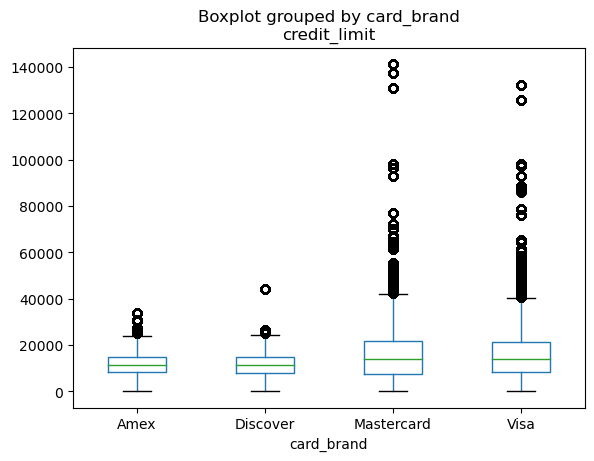

In [50]:
merged_df.boxplot(column=['credit_limit'], by='card_brand', grid=False)

### 7. Correlations & Relationships

Through creating a correlation heatmap and a pairplot, this provides a highlevel into any correlations in our dataset that should be explored. The correlation between number of cards and credit score as well as credit score and credit limit are weaker than expected.

<Axes: >

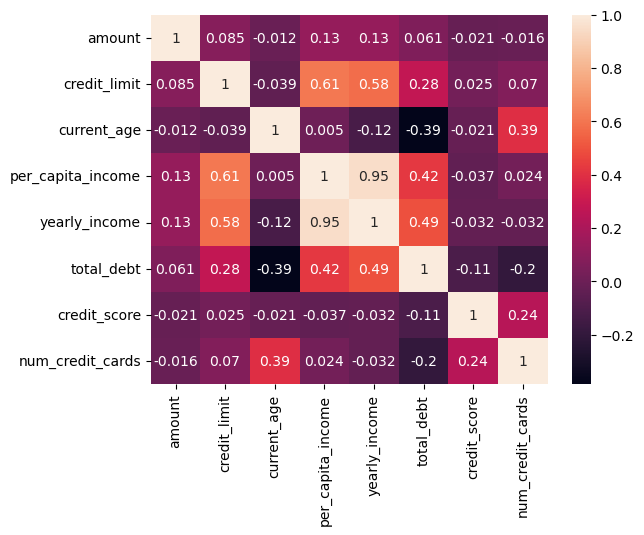

In [51]:
# creating a correlation heatmap with numerical values in the dataset
df_corr = merged_df[['amount','credit_limit', 'current_age', 'per_capita_income', 
                     'yearly_income', 'total_debt', 'credit_score','num_credit_cards']].corr()

sns.heatmap(df_corr, annot=True)

# expected correlation between number of cards + credit score and credit score + credit limit to be stronger

In [ ]:
# pairpot to explpore relevant columns relationships

sns.pairplot(merged_df, vars = ['amount','credit_limit', 'current_age', 'per_capita_income', 'yearly_income',
                                'total_debt', 'credit_score','num_credit_cards'])

## Predictive Model
### Customer Segmentation for Targeted Marketing Promotions in a Credit Dataset
    
This is a supervised learning model that predicts whether a customer will be high, medium, or low value (profitability) based on demographic, behavioral, and financial features.

This could help a company in a number of ways including but not limited to:
- Personalize marketing and offers
- Focus resources on high-value customers
- Reduce churn among medium/high-value users
- Better estimate lifetime value

### Profitability Score Construction

A composite profitability score was created using transaction behavior metrics,
including total transaction amount, average transaction amount, and number of
transactions.

These variables were scaled using MinMaxScaler to ensure they were on the same
range before applying weights. This prevents features with larger magnitudes
(e.g., total spend) from dominating the score.

The weighted profitability score was calculated as:

- 50% total transaction amount
- 30% transaction frequency
- 20% average transaction size

The continuous profitability score was then converted into Low, Medium, and High
profitability classes using the 25th and 75th percentiles.

Note: Feature scaling was used only in constructing the target variable and not
applied to model input features. Tree-based models were therefore trained on
unscaled predictor variables.

In [53]:
# Creating target/dependent variable (variable model will predict)

user_spend = transactions.groupby('client_id').agg(
    total_transaction_amount=('amount', 'sum'),
    avg_transaction_amount = ('amount', 'mean'),
    num_transactions = ('amount', 'count')
)

scaler = MinMaxScaler()
user_spend[['sum_scaled', 'avg_scaled', 'count_scaled']] = scaler.fit_transform(
    user_spend[['total_transaction_amount', 'avg_transaction_amount', 'num_transactions']]
)

# Weighted score
user_spend['profit_score'] = (
    0.5 * user_spend['sum_scaled'] +
    0.3 * user_spend['count_scaled'] +
    0.2 * user_spend['avg_scaled']
)


users_final_df = user_spend.merge(users, left_on='client_id', right_on='id', how='left')
users_final_df.shape
users_final_df.head()
users_final_df.query('id == 825')


# Define thresholds

q1 = users_final_df['profit_score'].quantile(0.25)
q3 = users_final_df['profit_score'].quantile(0.75)

def classify_profit(value):
    if value < q1:
        return "Low"
    elif value < q3:
        return "Medium"
    else:
        return "High"

users_final_df['profit_class'] = users_final_df['profit_score'].apply(classify_profit)
users_final_df['profit_class'].value_counts()

final_df = pd.merge(users_final_df, cards_data, left_on='id', right_on='client_id', how='left')

final_df.columns

Index(['total_transaction_amount', 'avg_transaction_amount',
       'num_transactions', 'sum_scaled', 'avg_scaled', 'count_scaled',
       'profit_score', 'id_x', 'current_age', 'retirement_age', 'birth_year',
       'birth_month', 'gender', 'address', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'age_group', 'income_class', 'profit_class', 'id_y',
       'client_id', 'card_brand', 'card_type', 'card_number', 'expires', 'cvv',
       'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_on_dark_web', 'account_age',
       'pin_change_gap'],
      dtype='object')

In [54]:
users_final_df.shape

(1219, 24)

One Hot Encoding was then applied to columns within the dataset that conttain nominal/categorical data. One Hot Encoding transforms cateogrical columns to be in a binary format that will allow the machine learning model we are using to better interpert the data.

In [55]:
# One Hot Encoding for nominal categorical data

# Creating an instance of the encoder
encoder = OneHotEncoder(sparse_output=False, drop='first') # (handle_unknown='ignore')

# transform the nominal columns and their categories into a one-hot encoded array
nominal_cols = ['gender', 'card_brand', 'card_type', 'has_chip']
encoded_data = encoder.fit_transform(final_df[nominal_cols])

# create new dataframe with encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(nominal_cols))

# merge back with full dataframe
final_df = pd.concat([final_df.drop(columns=nominal_cols), encoded_df], axis=1)

In [56]:
final_df.columns

Index(['total_transaction_amount', 'avg_transaction_amount',
       'num_transactions', 'sum_scaled', 'avg_scaled', 'count_scaled',
       'profit_score', 'id_x', 'current_age', 'retirement_age', 'birth_year',
       'birth_month', 'address', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards',
       'age_group', 'income_class', 'profit_class', 'id_y', 'client_id',
       'card_number', 'expires', 'cvv', 'num_cards_issued', 'credit_limit',
       'acct_open_date', 'year_pin_last_changed', 'card_on_dark_web',
       'account_age', 'pin_change_gap', 'gender_Male', 'card_brand_Discover',
       'card_brand_Mastercard', 'card_brand_Visa', 'card_type_Debit',
       'card_type_Debit (Prepaid)', 'has_chip_Yes'],
      dtype='object')

### Target Variable Encoding

Although the profitability classes (Low, Medium, High) are ordinal by nature,
they were intentionally treated as categorical labels rather than numeric values.

Tree-based models (Decision Trees and Random Forests) do not require numeric
ordering of the target variable and may incorrectly infer linear distances
between classes if ordinal encoding is used.

For this reason, the ordinal mapping was considered but not applied in modeling.

In [57]:
# selecting the prediciton target

# mapping the categorical optuons
# ordinal_mapping = {'Low': 1, 'Medium': 2, 'High': 3}

# Encode the ordinal target variable
#final_df['target'] = final_df['profit_class'].map(ordinal_mapping)

y = final_df.profit_class
y

0         High
1         High
2         High
3         High
4       Medium
         ...  
4509    Medium
4510    Medium
4511       Low
4512       Low
4513       Low
Name: profit_class, Length: 4514, dtype: object

The following is all the features we will be using to train our models on.

In [58]:
# selecting features

credit_features = ['account_age', 'pin_change_gap', 'current_age', 'birth_year', 'birth_month', 'latitude',
       'longitude', 'yearly_income', 'total_debt',
       'credit_score', 'num_credit_cards', 'gender_Male', 'card_brand_Discover',
       'card_brand_Mastercard', 'card_brand_Visa', 'card_type_Debit',
       'card_type_Debit (Prepaid)', 'has_chip_Yes']

X = final_df[credit_features]
X


,account_age,pin_change_gap,current_age,birth_year,birth_month,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards,gender_Male,card_brand_Discover,card_brand_Mastercard,card_brand_Visa,card_type_Debit,card_type_Debit (Prepaid),has_chip_Yes
0,12,5,33,1986,3,43.59,-70.33,59613,36199,763,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,8,8,33,1986,3,43.59,-70.33,59613,36199,763,4,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,-1,-1,33,1986,3,43.59,-70.33,59613,36199,763,4,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,-1,-1,33,1986,3,43.59,-70.33,59613,36199,763,4,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,7,7,43,1976,4,30.44,-87.18,45360,14587,704,3,0.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4509,13,6,76,1943,8,44.92,-93.40,38800,25867,758,7,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4510,15,8,76,1943,8,44.92,-93.40,38800,25867,758,7,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4511,12,12,65,1954,9,37.56,-122.37,645,790,688,3,1.0,0.0,0.0,1.0,0.0,1.0,1.0
4512,4,4,65,1954,9,37.56,-122.37,645,790,688,3,1.0,0.0,0.0,1.0,1.0,0.0,1.0


In the cell below, the dataset is being split in-between the training and validation set as well as being fit into our first model which is a Decision Tree model.

In [59]:
o# split data between training set and validation set
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)

# Define model - decision tree
profit_model = DecisionTreeClassifier(random_state = 1)

# Fit model
profit_model.fit(train_X, train_y)

# Making the Predictions
val_predictions = profit_model.predict(val_X)

Classification metrics were used instead of regression metrics such as MAE
because the target variable represents categorical profitability classes
(Low, Medium, High) rather than a continuous numeric value.

Although the classes are ordinal, the distance between them is not strictly
quantifiable, making regression-based error metrics inappropriate. Precision,
recall, F1-score, and confusion matrices provide more meaningful insights into
model performance and business trade-offs.

Accuracy: 0.9557130203720107
              precision    recall  f1-score   support

        High       0.96      0.96      0.96       264
         Low       0.96      0.91      0.93       262
      Medium       0.95      0.98      0.96       603

    accuracy                           0.96      1129
   macro avg       0.96      0.95      0.95      1129
weighted avg       0.96      0.96      0.96      1129



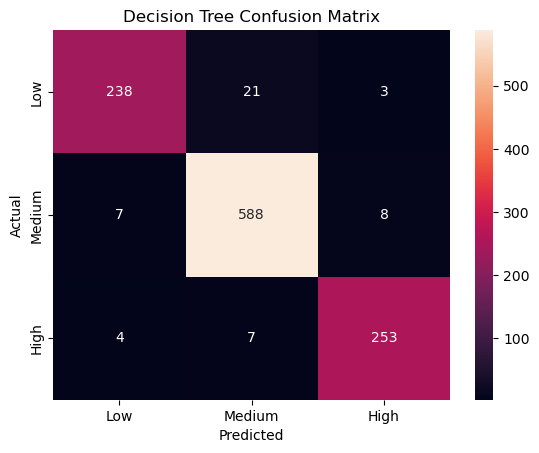

In [60]:
# validate decison tree model
print("Accuracy:", accuracy_score(val_y, val_predictions))
print(classification_report(val_y, val_predictions))

cm = confusion_matrix(val_y, val_predictions, labels=["Low", "Medium", "High"])

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Confusion Matrix")
plt.show()

Now our training set is being fit on a Random Forest model:

In [61]:
# model - random forest

forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(train_X, train_y)

# Making the Predictions
forest_preds = forest_model.predict(val_X)

In [62]:
pd.Series(
    forest_model.feature_importances_,
    index=credit_features
).sort_values(ascending=False).head(10)

yearly_income       0.182175
longitude           0.110876
total_debt          0.104895
latitude            0.103476
credit_score        0.096175
current_age         0.087496
birth_year          0.086409
birth_month         0.065157
num_credit_cards    0.055202
account_age         0.032205
dtype: float64

The same validation meterics performed on the decision tree model are now being applied to the random forest model

Accuracy: 0.9610274579273693
              precision    recall  f1-score   support

        High       0.99      0.95      0.97       264
         Low       0.98      0.90      0.94       262
      Medium       0.94      0.99      0.96       603

    accuracy                           0.96      1129
   macro avg       0.97      0.95      0.96      1129
weighted avg       0.96      0.96      0.96      1129



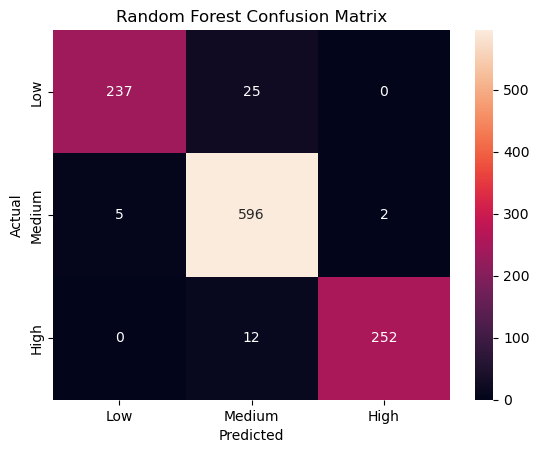

In [63]:
# validate Random Forest model
print("Accuracy:", accuracy_score(val_y, forest_preds))
print(classification_report(val_y, forest_preds))

cm = confusion_matrix(val_y, forest_preds, labels=["Low", "Medium", "High"])

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

Both models achieved similar overall accuracy (~96%), indicating that the
underlying features are highly predictive of customer profitability.

The Random Forest model showed slightly improved performance, particularly in
reducing severe misclassifications (e.g., predicting Low customers as High).
This improvement is expected, as Random Forests reduce variance by aggregating
multiple decision trees.

Overall, both models demonstrate strong performance in predicting customer
profitability. Most misclassifications occur between adjacent profitability
classes, which is expected given the quantile-based target construction.

Given its stronger robustness and marginally better class-level metrics, the
Random Forest model is more suitable for real-world deployment in finance or credit
analytics settings.

## Future Improvements

Potential next steps to improve this analysis include:

- Treating profitability as an **ordinal** or regression-based target
- Trying gradient boosting models (XGBoost, LightGBM)
- Engineering time-based transaction features
- Addressing potential class imbalance
- Adding explainability tools such as SHAP values

